Class Counts: {'wrinkles': 250, 'dark spots': 272, 'puffy eyes': 246, 'clear skin': 298}


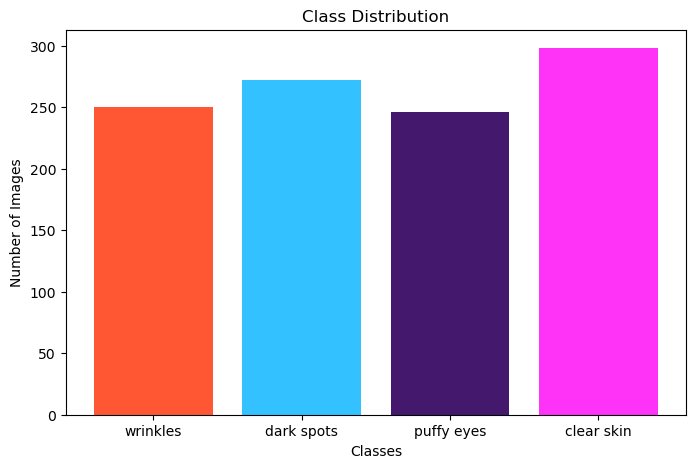

In [1]:
import os
import matplotlib.pyplot as plt

DATASET_DIR = "C:/Dermal_AI/DATASET"

CLASSES = ["wrinkles", "dark spots", "puffy eyes", "clear skin"]

def scan_dataset(dataset_dir=DATASET_DIR):
    class_counts = {}
    
    for cls in CLASSES:
        folder = os.path.join(dataset_dir, cls)
        
        count = len(os.listdir(folder))
        class_counts[cls] = count

    return class_counts

def plot_class_distribution(counts):
    plt.figure(figsize=(8,5))
    colors = ["#FF5733", "#33C1FF", "#44196D", "#FF33F8"]
    plt.bar(counts.keys(), counts.values(),color=colors)
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()

if __name__ == "__main__":
    counts = scan_dataset()
    print("Class Counts:", counts)
    plot_class_distribution(counts)


In [2]:
import os

print(os.path.exists("C:/Dermal_AI/DATASET"))
print(os.listdir("C:/Dermal_AI/DATASET"))


True
['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


In [3]:
import os

DATASET_DIR = "dataset"
VALID_EXT = (".jpg", ".jpeg", ".png")

for root, dirs, files in os.walk(DATASET_DIR):
    for file in files:
        if not file.lower().endswith(VALID_EXT):
            path = os.path.join(root, file)
            print("Removing:", path)
            try:
                os.remove(path)
            except Exception as e:
                print("Could not remove:", path, e)


In this cell, we apply data augmentation to our training dataset using TensorFlow ImageDataGenerator. Augmentation helps improve model generalization by creating 
multiple transformed versions of the existing images.

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)

augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    validation_split=0.2
)


train_gen = augmentation.flow_from_directory(
    "dataset",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_gen = augmentation.flow_from_directory(
    "dataset",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)
print(train_gen.class_indices)



Found 854 images belonging to 4 classes.
Found 212 images belonging to 4 classes.
{'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}


The below Cell contain script to show the augemented Images generated from the training batch. This helps us visually verify that the augmentation is working 
correctly.

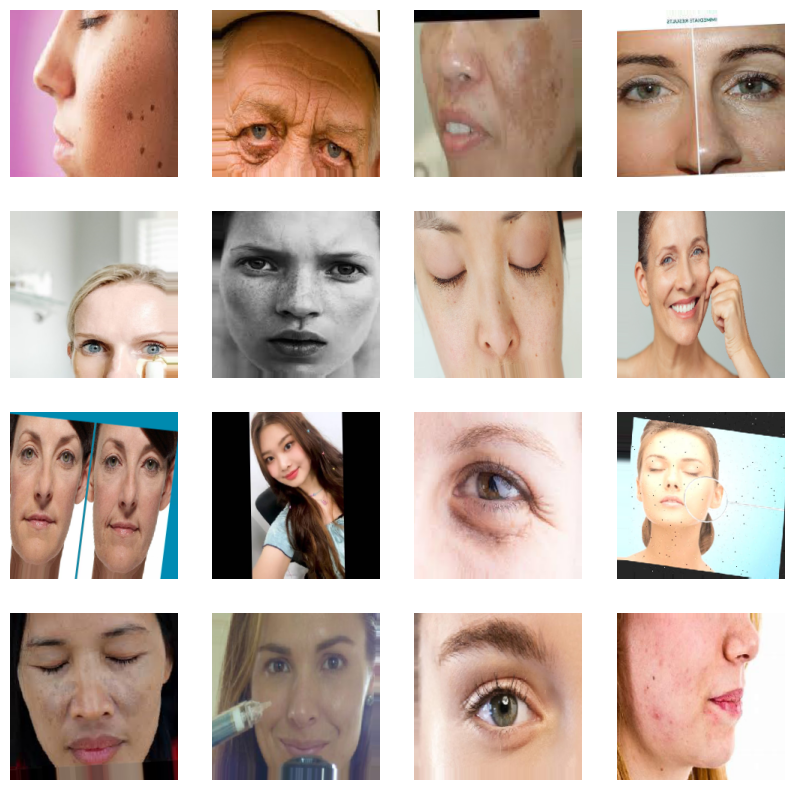

In [5]:
import numpy as np
import matplotlib.pyplot as plt

images, labels = next(train_gen)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os


In [7]:
DATASET_DIR = "dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50   # ✅ mentor requirement
NUM_CLASSES = 4


In [8]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [9]:
train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 854 images belonging to 4 classes.
Found 212 images belonging to 4 classes.


In [10]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [13]:
os.makedirs("models", exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        patience=5,
        factor=0.3,
        verbose=1
    ),
    ModelCheckpoint(
        "models/best_model.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]


In [14]:
from PIL import Image
import os

DATASET_DIR = "dataset"
bad = []

for root, _, files in os.walk(DATASET_DIR):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(root, f)
            try:
                Image.open(p).verify()
            except:
                bad.append(p)

print("Bad images found:", len(bad))
for p in bad:
    os.remove(p)


Bad images found: 0


In [15]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.2699 - loss: 1.7517
Epoch 1: val_loss improved from None to 1.31528, saving model to models/best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 606ms/step - accuracy: 0.2892 - loss: 1.6864 - val_accuracy: 0.4198 - val_loss: 1.3153 - learning_rate: 1.0000e-04
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.3869 - loss: 1.4553
Epoch 2: val_loss improved from 1.31528 to 1.09163, saving model to models/best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 413ms/step - accuracy: 0.3993 - loss: 1.3705 - val_accuracy: 0.5094 - val_loss: 1.0916 - learning_rate: 1.0000e-04
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.4314 - loss: 1.2357
Epoch 3: val_loss improved from 1.09163 to 0.94757, saving model to models/best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 420ms/step - accuracy: 0.4520 - loss: 1.1980 - val_accuracy: 0.6321 - val_loss: 0.9476 - learning_rate: 1.0000e-04
Epoch 4/50
54/54 ━━━━━━━━━━━━━━

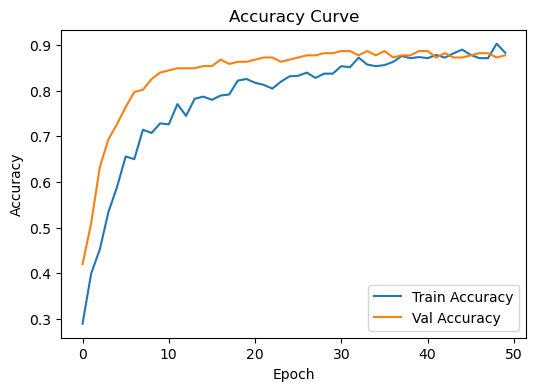

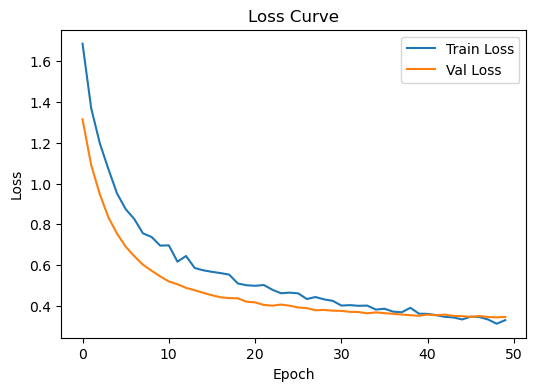

In [16]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


In [17]:
model.save("models/final_model.keras")


In [18]:
loss, acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {acc*100:.2f}%")
print(f"Validation Loss: {loss:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.8726 - loss: 0.3435
Validation Accuracy: 87.26%
Validation Loss: 0.3435


In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image

img = image.load_img(
    "C:/Dermal_AI/DATASET/wrinkles/1.jpg",
    target_size=(224, 224)
)
img = image.img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)

pred = model.predict(img)
class_name = list(train_gen.class_indices.keys())[np.argmax(pred)]

print("Predicted class:", class_name)
print("Confidence:", np.max(pred)*100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: wrinkles
Confidence: 75.73


In [20]:
import cv2
print(cv2.__version__)


4.12.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


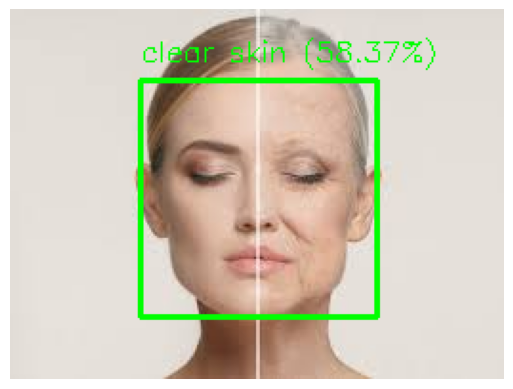

In [25]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load trained skin-condition model
skin_model = tf.keras.models.load_model(
    r"D:\Dermal_Ai\models\final_model.keras"
)

CLASSES = ["wrinkles", "dark spots", "puffy eyes", "clear skin"]

# Face detector
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

# Load image
img = cv2.imread(r"C:\Dermal_Ai\DATASET\wrinkles\1.jpg")

if img is None:
    raise FileNotFoundError("Image not found. Check the image path.")


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x, y, w, h) in faces:
    face = img[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))
    face = face / 255.0
    face = np.expand_dims(face, axis=0)

    preds = skin_model.predict(face)
    label = CLASSES[np.argmax(preds)]

    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
    cv2.putText(img, label, (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    
preds = skin_model.predict(face)[0]

class_index = np.argmax(preds)
label = CLASSES[class_index]
confidence = preds[class_index] * 100

text = f"{label} ({confidence:.2f}%)"

cv2.putText(
    img, text, (x, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1
)
pad = int(0.15 * w)  # 15% padding
x1 = max(x + pad, 0)
y1 = max(y + pad, 0)
x2 = min(x + w - pad, img.shape[1])
y2 = min(y + h - pad, img.shape[0])

face = img[y1:y2, x1:x2]


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [22]:
import os
print(os.path.exists(r"D:\Dermal_Ai\models\final_model.keras"))


True
